In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
import math
from math import ceil

Using TensorFlow backend.


In [3]:
#Imports
import os
import pandas as pd
import numpy as np
import cv2
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import math
from matplotlib import pyplot as plt
from keras.layers import Convolution2D, BatchNormalization, MaxPool2D, Activation, Dropout
from keras.layers import GlobalAveragePooling2D

In [4]:
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
n = 3
depth = n * 9 + 2

In [5]:
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
# define the minimum learning rate, maximum learning rate, batch size,
# step size, CLR method, and number of epochs
MIN_LR = 1e-3
MAX_LR = 0.05
BATCH_SIZE = batch_size
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 48

#num_classes = 10

In [6]:
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, 2)

In [7]:
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [8]:
df = pd.read_csv('hvc_annotations.csv')
del df['filename']

In [9]:
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [10]:
one_hot_df = pd.concat([
    df[['image_path']],
    pd.get_dummies(df.gender, prefix='gender'),
    pd.get_dummies(df.imagequality, prefix='imagequality'),
    pd.get_dummies(df.age, prefix='age'),
    pd.get_dummies(df.weight, prefix='weight'),
    pd.get_dummies(df.carryingbag, prefix='carryingbag'),
    pd.get_dummies(df.footwear, prefix='footwear'),
    pd.get_dummies(df.emotion, prefix='emotion'),
    pd.get_dummies(df.bodypose, prefix='bodypose'),
], axis=1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [11]:
_gender_cols = [col for col in one_hot_df.columns if col.startswith('gender')]
_imagequality_cols = [col for col in one_hot_df.columns if col.startswith('imagequality')]
_age_cols = [col for col in one_hot_df.columns if col.startswith('age')]
_weight_cols = [col for col in one_hot_df.columns if col.startswith('weight')]
_carryingbag_cols = [col for col in one_hot_df.columns if col.startswith('carryingbag')]
_footwear_cols = [col for col in one_hot_df.columns if col.startswith('footwear')]
_emotion_cols = [col for col in one_hot_df.columns if col.startswith('emotion')]
_bodypose_cols = [col for col in one_hot_df.columns if col.startswith('bodypose')]

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',)
validation_datagen = ImageDataGenerator(
    rescale=1. / 255)

In [13]:
class PersonDataGenerator(keras.utils.Sequence):
    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation
        
    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))
    
    def __getitem__(self, index):
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.resize(cv2.imread(item['image_path']), (112, 112)) for _, item in items.iterrows()])
        image = self.augmentation.flow(image, shuffle=False, batch_size=self.batch_size).next()
        target = {
            'gender_output': items[_gender_cols].values,
            'image_quality_output': items[_imagequality_cols].values,
            'age_output': items[_age_cols].values,
            'weight_output': items[_weight_cols].values,
            'bag_output': items[_carryingbag_cols].values,
            'pose_output': items[_bodypose_cols].values,
            'footwear_output': items[_footwear_cols].values,
            'emotion_output': items[_emotion_cols].values,
        }
        return image, target
    
    def on_epoch_end(self):
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            

In [14]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [15]:
train_df.head(2)

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,...,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
5149,resized/5150.jpg,0,1,0,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,0,1
12659,resized/12661.jpg,1,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0


In [16]:
train_gen = PersonDataGenerator(train_df, batch_size=batch_size, augmentation=train_datagen)
valid_gen = PersonDataGenerator(val_df, batch_size=batch_size, shuffle=False, augmentation=validation_datagen)

In [17]:
images, targets = next(iter(train_gen))
num_units = {k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'gender': 2,
 'image_quality': 3,
 'age': 5,
 'weight': 4,
 'bag': 3,
 'pose': 3,
 'footwear': 3,
 'emotion': 4}

In [18]:
images.shape

(32, 112, 112, 3)

In [19]:
input_shape = images.shape[1:]

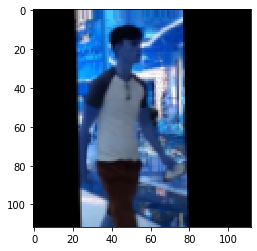

In [20]:
plt.imshow(images[0])

In [21]:
from keras.callbacks import *


class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2. ** (x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** (x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(
                self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

In [22]:
stepSize = STEP_SIZE * (len(train_gen))
clr = CyclicLR(
    mode=CLR_METHOD,
    base_lr=MIN_LR,
    max_lr=MAX_LR,
    step_size=stepSize)

In [23]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound,
                             dtype=dtype)

In [24]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer=init_pytorch,
                  kernel_regularizer=l2(1e-4),
                  use_bias=False)

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [25]:
def resnet_v2(input_shape, depth, num_classes=10):
    
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
    print('num_res_blocks ', num_res_blocks)
    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(5):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
        
        num_filters_in = num_filters_out

    # Add classifier on top.
    neck = x
    print(x.shape)
    # v2 has BN-ReLU before Pooling
    #     x = BatchNormalization()(x)
    #     x = Activation('relu')(x)
    #     x = AveragePooling2D(pool_size=8)(x)
    #     y = Flatten()(x)
    
    
    #     outputs = Dense(num_classes,
    #                     activation='softmax',
    #                     kernel_initializer='he_normal')(y)
    def build_tower(in_layer):
        in_layer = Convolution2D(256, 3, activation='relu',
                                 kernel_initializer=init_pytorch,
                                 use_bias=False )(in_layer)
        in_layer = BatchNormalization()(in_layer)
        in_layer = Dropout(0.2)(in_layer)
        
        in_layer = MaxPool2D()(in_layer)
        in_layer = Activation('relu')(in_layer)

        #in_layer = Dropout(0.2)(in_layer)
        
        in_layer = Convolution2D(128, 1, activation='relu',
                                 kernel_initializer=init_pytorch,
                                 use_bias=False)(in_layer)
        in_layer = BatchNormalization()(in_layer)
        in_layer = Activation('relu')(in_layer)
        in_layer = Dropout(0.2)(in_layer)
        
                
        in_layer = MaxPool2D()(in_layer)
        #in_layer = Dropout(0.2)(in_layer)
        
        return in_layer
    
    def build_head(name, in_layer):
        print(in_layer.shape)
        in_layer = BatchNormalization()(in_layer)
        in_layer = Activation('relu')(in_layer)
        in_layer = Convolution2D(num_units[name], 1,
                                 kernel_initializer=init_pytorch,
                                 use_bias=False)(in_layer)
        in_layer = GlobalAveragePooling2D()(in_layer)
        return Activation(activation='softmax', name=f"{name}_output")(in_layer)
    
    gender = build_head('gender', build_tower(neck))
    image_quality = build_head('image_quality', build_tower(neck))
    age = build_head('age', build_tower(neck))
    weight = build_head('weight', build_tower(neck))
    bag = build_head('bag', build_tower(neck))
    footwear = build_head('footwear', build_tower(neck))
    emotion = build_head('emotion', build_tower(neck))
    pose = build_head('pose', build_tower(neck))
    
    # Instantiate model.
    #model = Model(inputs=inputs, outputs=outputs)
    
    model = Model(inputs=inputs,
             outputs=[gender, image_quality, age, weight, bag, footwear, emotion, pose])
    return model

model = resnet_v2(input_shape=input_shape, depth=depth)

num_res_blocks  3










(?, 7, 7, 1024)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

(?, 1, 1, 128)
(?, 1, 1, 128)
(?, 1, 1, 128)
(?, 1, 1, 128)
(?, 1, 1, 128)
(?, 1, 1, 128)
(?, 1, 1, 128)
(?, 1, 1, 128)


In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [27]:
from keras.optimizers import SGD

In [28]:
opt = SGD(lr=MIN_LR, momentum=0.9)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [29]:
history = model.fit_generator(generator=train_gen,
                   validation_data=valid_gen,
                   use_multiprocessing=True,
                   workers=6,
                   epochs=100,
                   verbose=1,
                   callbacks=[clr])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
360/360 [==============================] - 115s 320ms/step - loss: 8.6020 - gender_output_loss: 0.6858 - image_quality_output_loss: 1.0157 - age_output_loss: 1.4748 - weight_output_loss: 1.0422 - bag_output_loss: 0.9554 - footwear_output_loss: 1.0143 - emotion_output_loss: 0.9784 - pose_output_loss: 0.9654 - gender_output_acc: 0.5629 - image_quality_output_acc: 0.5310 - age_output_acc: 0.3710 - weight_output_acc: 0.6174 - bag_output_acc: 0.5398 - footwear_output_acc: 0.5049 - emotion_output_acc: 0.6959 - pose_output_acc: 0.6062 - val_loss: 8.5740 - val_gender_output_loss: 0.8083 - val_image_quality_output_loss: 0.9970 - val_age_output_loss: 1.4282 - val_weight_output_loss: 1.0508 - val_bag_output_loss: 0.9310 - val_footwear_output_loss: 0.9869 - val_emotion_output_loss: 0.9129 - val_pose_output_loss: 0.9891 - val_gender_output_acc: 0.4572 - val_image_quality_output_acc: 0.5474 - 

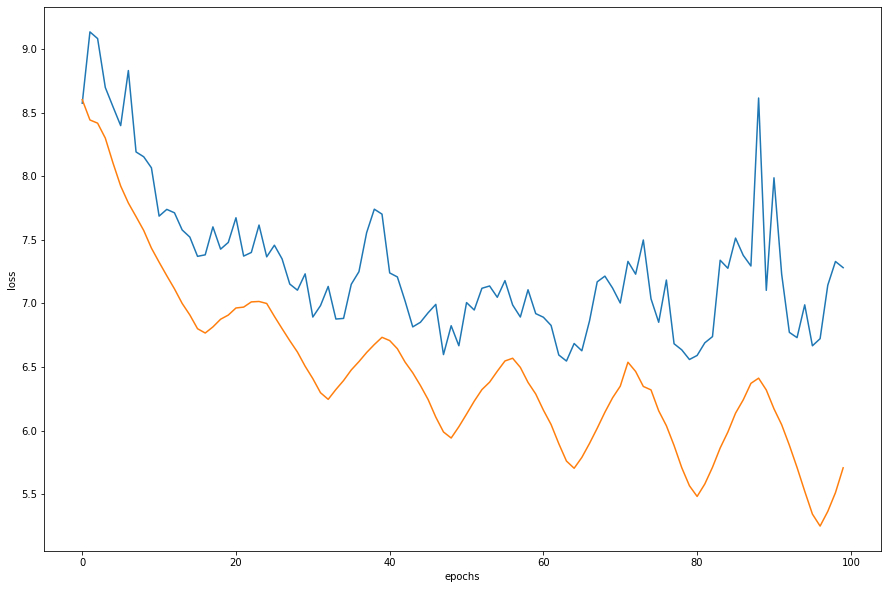

In [30]:
plt.figure(figsize=(15, 10))
plt.plot(history.epoch, history.history['val_loss'])
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
history = model.fit_generator(generator=train_gen,
                   validation_data=valid_gen,
                   use_multiprocessing=True,
                   callbacks=[clr],
                   workers=6,
                   epochs=20,
                   verbose=1)

Epoch 1/20
360/360 [==============================] - 107s 297ms/step - loss: 5.8686 - gender_output_loss: 0.1984 - image_quality_output_loss: 0.8342 - age_output_loss: 1.1570 - weight_output_loss: 0.7841 - bag_output_loss: 0.6333 - footwear_output_loss: 0.6699 - emotion_output_loss: 0.7750 - pose_output_loss: 0.3162 - gender_output_acc: 0.9230 - image_quality_output_acc: 0.6076 - age_output_acc: 0.4913 - weight_output_acc: 0.6813 - bag_output_acc: 0.7336 - footwear_output_acc: 0.7102 - emotion_output_acc: 0.7172 - pose_output_acc: 0.8799 - val_loss: 7.3841 - val_gender_output_loss: 0.3515 - val_image_quality_output_loss: 1.0024 - val_age_output_loss: 1.4377 - val_weight_output_loss: 1.0045 - val_bag_output_loss: 0.8230 - val_footwear_output_loss: 0.8393 - val_emotion_output_loss: 0.9137 - val_pose_output_loss: 0.5062 - val_gender_output_acc: 0.8483 - val_image_quality_output_acc: 0.4904 - val_age_output_acc: 0.3548 - val_weight_output_acc: 0.6154 - val_bag_output_acc: 0.6613 - val_foo

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(history.epoch, history.history['val_loss'])
plt.plot(history.epoch, history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
history.epoch

In [ ]:
history.history

In [ ]:
plt.plot(history.epoch, history.history['val_loss'])

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

In [ ]:
keras.__version__

In [ ]:
from keras.callbacks import LambdaCallback
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile

class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta

        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []

        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def reset(self):
        # re-initialize all variables from our constructor
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def is_data_iter(self, data):
        # define the set of class types we will check for
        iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
             "Iterator", "Sequence", "PersonDataGenerator"]

        # return whether our data is an iterator
        return data.__class__.__name__ in iterClasses

    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add log it to the list of
        # learning rates that we've tried
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)

        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss

        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return

        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth

        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, trainData, startLR, endLR, epochs=None,
        stepsPerEpoch=None, batchSize=32, sampleSize=2048,
        verbose=1):
        # reset our class-specific variables
        self.reset()

        # determine if we are using a data generator or not
        useGen = self.is_data_iter(trainData)

        # if we're using a generator and the steps per epoch is not
        # supplied, raise an error
        if useGen and stepsPerEpoch is None:
            msg = "Using generator without supplying stepsPerEpoch"
            raise Exception(msg)

        # if we're not using a generator then our entire dataset must
        # already be in memory
        elif not useGen:
            # grab the number of samples in the training data and
            # then derive the number of steps per epoch
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))

        # if no number of training epochs are supplied, compute the
        # training epochs based on a default sample size
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))

        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch

        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)

        # create a temporary file path for the model weights and
        # then save the weights (so we can reset the weights when we
        # are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)

        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)

        # construct a callback that will be called at the end of each
        # batch, enabling us to increase our learning rate as training
        # progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))

        # check to see if we are using a data iterator
        if useGen:
            self.model.fit_generator(
                trainData,
                steps_per_epoch=stepsPerEpoch,
                epochs=epochs,
                verbose=verbose,
                callbacks=[callback])

        # otherwise, our entire training data is already in memory
        else:
            # train our model using Keras' fit method
            self.model.fit(
                trainData[0], trainData[1],
                batch_size=batchSize,
                epochs=epochs,
                callbacks=[callback],
                verbose=verbose)

        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)

    def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]

        # plot the learning rate vs. loss
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")

        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)

In [ ]:
check_lr = True

In [ ]:
if check_lr:
    # initialize the learning rate finder and then train with learning
    # rates ranging from 1e-10 to 1e+1
    print("[INFO] finding learning rate...")
    lrf = LearningRateFinder(model)
    lrf.find(
        train_gen,
        1e-10, 1e+1,
        stepsPerEpoch=np.ceil(len(train_gen)),
        batchSize=BATCH_SIZE,
        epochs=2)
    
    # plot the loss for the various learning rates and save the
    # resulting plot to disk
    lrf.plot_loss()
    #plt.savefig(config.LRFIND_PLOT_PATH)
    plt.show()

In [ ]:
upper = 0.5
lower = 0.01